In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [3]:
tf.__version__

'1.13.1'

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 1. 准备数据

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') #新增加的维度所有数值均为-1
train_images = (train_images - 127.5) / 127.5 #归一化（好像不做也可以）

#### 将数据划分为大小为256的batchs

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [111]:
train_dataset?

# 2. 建立模型

## 2.1 Generator

Generator通过100 x 1的noise产生28 x 28的图像

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    #第一个全连接层
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    #assert： 保证若条件不成立时直接停止执行

    #第一个卷积层
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #第二个卷积层
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #第三个卷积层
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#### 随机产生一张图

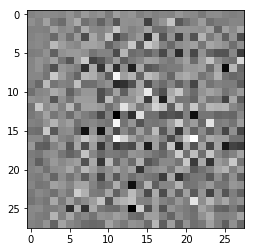

In [20]:
generator = make_generator_model()
#
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 2.2 Discriminator

包含两个卷积层

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(rate=0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(rate=0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00254098]], shape=(1, 1), dtype=float32)


# 3. Loss and optimizer

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 3.1 Generator loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## 3.2 Discriminator loss

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [38]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

# 4. 模型训练

只运行了15个epoch，时间太久了，CPU上15个epoch运行了3个小时,但是已经可以看到明显的图像变清晰。

保存checkpoints

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ValueError: `Checkpoint` was expecting a checkpointable object (an object derived from `CheckpointableBase`), got <tensorflow.python.keras.optimizers.Adam object at 0x00000155839E5F28>. If you believe this object should be checkpointable (i.e. it is part of the TensorFlow Python API and manages state), please open an issue.

In [39]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [40]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [36]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 保存图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每15个epoch保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [41]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

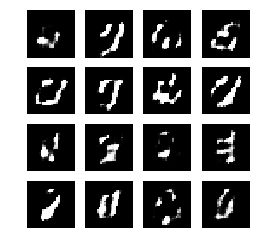

NameError: name 'checkpoint' is not defined

In [42]:
%%time
train(train_dataset, EPOCHS)

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

NameError: name 'checkpoint' is not defined

## 生成动图

In [44]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [45]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

In [46]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)